### To do list:
#### 1. ~~Скачать датасет *VGGSound*. Ссылка: https://huggingface.co/datasets/Loie/VGGSound/tree/main~~
#### 2. ~~Все видео-файлы заменить на случайный кадр из них~~
#### 2.1 Перевести wav файлы к частоте 48кГц
#### 3. ~~Реализовать DataLoader wav->ipeg~~
#### 4. Встроить аудио-энкодер. Ссылка: https://github.com/archinetai/archisound
#### 5. Реализовать сценарий обучения и обучить модель

In [1]:
import torch
from utils.config import ModelConfig
from models.unet import UNetWithCrossAttention
from models.diffusion import Diffusion
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

config = ModelConfig({
                    "image_size": 256,
                    "audio_ctx_dim": 100
                    })

model = UNetWithCrossAttention(config)

diffusion = Diffusion(timesteps=100, image_size=256, device=device)

In [3]:
audio_embeds = torch.randn(1, 10, 100)

generated_image = diffusion.reverse_process(
    model,
    audio_embeds,
    batch_size=1,
    use_ddim=True,
    timesteps=50  # во сколько раз сокращаем число шагов
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


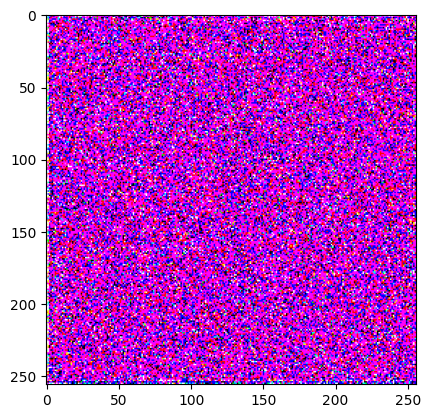

In [4]:
plt.imshow(torch.permute(generated_image[0], (1,2,0)).numpy())

In [41]:
from torch.utils.data import Dataset
import glob
from torchvision.io import read_image
import torchaudio
import torch

class SoundDataset(Dataset):
    def __init__(self , image_path, sound_path):
        names = []
        for path in glob.glob(f'{image_path}/*.jpg'):
            name = path.split('/')[-1][:-4]
            names.append(name)

        self.names = names
        self.im_path = image_path
        self.au_path = sound_path
        self.stanart_len = 441000

    def __len__(self):
        return len(self.names)

    def __getitem__(self , index):
        image = read_image(f"{self.im_path}/{self.names[index]}.jpg")/255.0
        
        audio_path = f"{self.au_path}/{self.names[index]}.wav"
        waveform, _ = torchaudio.load(audio_path)
        
        # необходим стерео звук, если он одноканальный то приводим к стерео
        if waveform.shape[0] == 1:
            stereo = torch.zeros((2, waveform.shape[1]), dtype=torch.float)
            stereo[0] = waveform[0]
            stereo[1] = waveform[0]
            waveform = stereo

        elif waveform.shape[0] != 2:
            raise ValueError(f"audio {self.names[index]} must be stereo or mono, but {waveform.shape[0]} channels were given")

        # все тензоры должны быть стандартного размера (только для обучения)
        if waveform.shape[1] < self.stanart_len:
            ext_waveform = torch.zeros((2, self.stanart_len), dtype=torch.float)
            ext_waveform[:, :waveform.shape[1]] = waveform
            waveform = ext_waveform
        elif waveform.shape[1] > self.stanart_len:
            waveform = waveform[:, self.stanart_len]
        
        return waveform.float(), image.float()

In [42]:
image_path = "data/images"
sound_path = "data/sounds"

data = SoundDataset(image_path, sound_path)
loader = DataLoader(data, batch_size=4, shuffle=False)

In [43]:
waveform, image = data[3]

In [44]:
waveform.shape

torch.Size([2, 441000])

In [45]:
next(iter(loader))[0].shape

torch.Size([4, 2, 441000])